# Ingest data - Task 0

In [3]:
import duckdb

# "r" - read mode for the file we open
with open("sql/load_sakila.sql", "r") as sql_file:
    loading_script = sql_file.read()

print(loading_script)

INSTALL sqlite;

LOAD sqlite;

CALL sqlite_attach('data/sqlite-sakila.db');


In [91]:
from pathlib import Path

duckdb_path = "data/sakila.duckdb"

# throws away sakila.duckdb if it exists -> makes it idempotent
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn:
    conn.sql(loading_script)

    description = conn.sql("desc;").df()
    films = conn.sql("FROM film;").df()

In [5]:
films.sample(2)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
695,696,PRIDE ALAMO,A Thoughtful Drama of a A Shark And a Forensic...,2006,1,<NA>,6,0.99,114,20.99,NC-17,Deleted Scenes,2021-03-06 15:52:06
38,39,ARMAGEDDON LOST,A Fast-Paced Tale of a Boat And a Teacher who ...,2006,1,<NA>,5,0.99,99,10.99,G,Trailers,2021-03-06 15:52:01


# EDA in python - Task 1

In [6]:
films.columns

Index(['film_id', 'title', 'description', 'release_year', 'language_id',
       'original_language_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features', 'last_update'],
      dtype='object')

### a) Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [95]:
def query_sakila(query: str, duckdb_path="data/sakila.duckdb"):
    with duckdb.connect(duckdb_path) as conn:
        df = conn.sql(query=query).df()

    return df

query_sakila("""--sql
             SELECT 
                title AS title,
                length AS length
             FROM films
             WHERE length > 180;
             """).head(10)

,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184
5,CONTROL ANTHEM,185
6,CRYSTAL BREAKING,184
7,DARN FORRESTER,185
8,FRONTIER CABIN,183
9,GANGS PRIDE,185


### b) Which movies have the word "love" in its title? Show the following columns: title, rating, length, description.

In [ ]:
query_sakila(
    "SELECT title, rating, length, description FROM films WHERE title ILIKE '%love%';"
)

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
6,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
7,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
8,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
9,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


### c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

In [33]:
query_sakila(
    """SELECT MIN(length) AS min_length, 
    MAX(length) AS max_length, 
    MEDIAN(length) AS median_length, 
    AVG(length) AS average_length 
    FROM films;
"""
)

,min_length,max_length,median_length,average_length
0,46,185,114.0,115.272


### d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.


In [ ]:
query_sakila("""--sql
SELECT 
    title, 
    rental_rate,
    rental_duration,
    rental_rate/rental_duration AS price_per_day 
    FROM films 
    ORDER BY price_per_day;
""").tail(10)

,title,rental_rate,rental_duration,price_per_day
990,DUDE BLINDNESS,4.99,3,1.663333
991,STRANGER STRANGERS,4.99,3,1.663333
992,PARK CITIZEN,4.99,3,1.663333
993,SUGAR WONKA,4.99,3,1.663333
994,SUIT WALLS,4.99,3,1.663333
995,PATHS CONTROL,4.99,3,1.663333
996,SUNRISE LEAGUE,4.99,3,1.663333
997,HEARTBREAKERS BRIGHT,4.99,3,1.663333
998,VELVET TERMINATOR,4.99,3,1.663333
999,KING EVOLUTION,4.99,3,1.663333


### e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have played in.

In [97]:
films_joined = query_sakila("""--sql
    SELECT 
        CONCAT(a.first_name, ' ', a.last_name) AS actor,
        COUNT(fa.film_id) AS count_movies
    FROM actor a
        JOIN film_actor fa ON a.actor_id = fa.actor_id
        GROUP BY a.actor_id, actor
        ORDER BY count_movies DESC;
             """)

films_joined.head(10)

,actor,count_movies
0,GINA DEGENERES,42
1,WALTER TORN,41
2,MARY KEITEL,40
3,MATTHEW CARREY,39
4,SANDRA KILMER,37
5,SCARLETT DAMON,36
6,HENRY BERRY,35
7,ANGELA WITHERSPOON,35
8,VIVIEN BASINGER,35
9,GROUCHO DUNST,35


### f) Which is the most common movie category? list top 10.  

In [ ]:
film_category = query_sakila("""--sql
    SELECT 
    c.name AS category_name,
    COUNT(fc.film_id) AS count_category
FROM category c
JOIN film_category fc 
    ON c.category_id = fc.category_id
GROUP BY c.name
ORDER BY count_category DESC;
""")

film_category.head(10)


,category_name,count_category
0,Sports,74
1,Foreign,73
2,Family,69
3,Documentary,68
4,Animation,66
5,Action,64
6,New,63
7,Drama,62
8,Games,61
9,Sci-Fi,61


### g) List the topp 10 customers who have rented the most movies.  

In [94]:
customer_who_rented_the_most_movies = query_sakila("""--sql
SELECT 
    CONCAT(c.first_name, ' ', c.last_name) AS full_name,
    COUNT(r.rental_id) AS total_rentals
FROM customer c
JOIN rental r 
    ON c.customer_id = r.customer_id
GROUP BY full_name
ORDER BY total_rentals DESC;
""")

customer_who_rented_the_most_movies.head(10)

,full_name,total_rentals
0,ELEANOR HUNT,46
1,KARL SEAL,45
2,MARCIA DEAN,42
3,CLARA SHAW,42
4,TAMMY SANDERS,41
5,SUE PETERS,40
6,WESLEY BULL,40
7,MARION SNYDER,39
8,RHONDA KENNEDY,39
9,TIM CARY,39


### h) Which country rents the most movies per person, list the top 10 

##### Här använde jag ai för att få uträkningen rätt

In [ ]:
county_that_rented_the_most_movies_per_person = query_sakila("""--sql
SELECT
    co.country,
    COUNT(r.rental_id) * 1.0 / COUNT(DISTINCT cu.customer_id) AS rentals_per_person,
    COUNT(r.rental_id) AS total_rentals,
    COUNT(DISTINCT cu.customer_id) AS total_customers
FROM country co
JOIN city ci 
    ON co.country_id = ci.country_id
JOIN address a 
    ON ci.city_id = a.city_id
JOIN customer cu 
    ON a.address_id = cu.address_id
JOIN rental r 
    ON cu.customer_id = r.customer_id
GROUP BY co.country
ORDER BY rentals_per_person DESC;
""")

county_that_rented_the_most_movies_per_person.head(10)

,country,rentals_per_person,total_rentals,total_customers
0,Runion,46.0,46,1
1,Anguilla,35.0,35,1
2,Brunei,35.0,35,1
3,Greenland,34.0,34,1
4,Holy See (Vatican City State),34.0,34,1
5,Moldova,34.0,34,1
6,Sweden,34.0,34,1
7,Zambia,33.0,33,1
8,Belarus,33.0,66,2
9,Chad,32.0,32,1


# Graphs - Task 2

### Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them with special offers. Create a bar chart showing the top 5 customers by total spend.


matplotlib.axes._axes.Axes

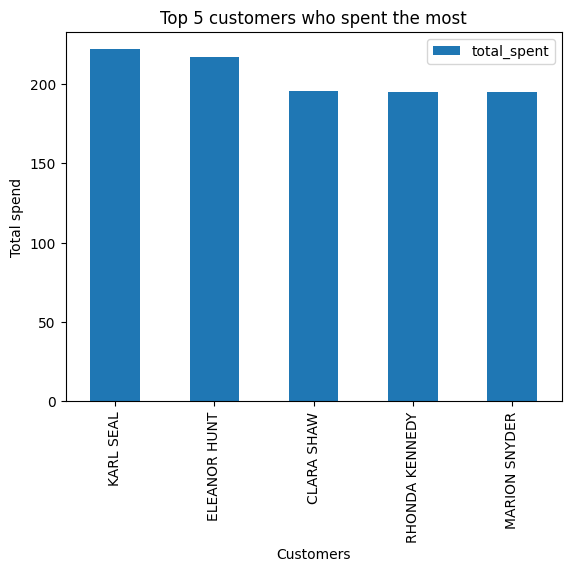

In [83]:
import matplotlib as plt

most_spening_customers = query_sakila("""--sql
SELECT 
    CONCAT(c.first_name, ' ', c.last_name) AS full_name,
    SUM(p.amount) AS total_spent
FROM customer c
JOIN payment p 
    ON c.customer_id = p.customer_id
GROUP BY c.customer_id, full_name
ORDER BY total_spent DESC;
""")

ax = most_spening_customers.head(5).plot(
    x="full_name",
    y="total_spent",
    kind="bar",
    xlabel="Customers",
    ylabel="Total spend",
    title = "Top 5 customers who spent the most"
)

type(ax)

### b) How much money does each film category bring in? Make a bar chart showing total revenue per film category.

matplotlib.axes._axes.Axes

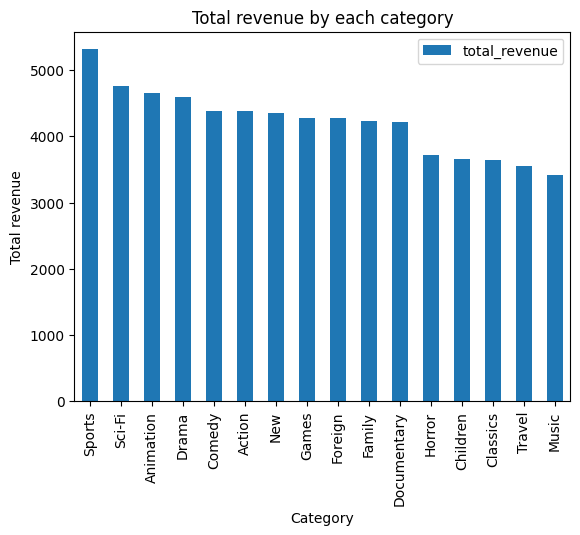

In [85]:
total_revenue = query_sakila("""--sql
SELECT 
    c.name AS category_name,
    SUM(p.amount) AS total_revenue
FROM category c
JOIN film_category fc 
    ON c.category_id = fc.category_id
JOIN film f
    ON fc.film_id = f.film_id
JOIN inventory i
    ON f.film_id = i.film_id
JOIN rental r
    ON i.inventory_id = r.inventory_id
JOIN payment p
    ON r.rental_id = p.rental_id
GROUP BY c.name
ORDER BY total_revenue DESC;
""")

ax = total_revenue.plot(
    x="category_name",
    y="total_revenue",
    kind="bar",
    xlabel="Category",
    ylabel="Total revenue",
    title = "Total revenue by each category"
)

type(ax)